# Image embeddings with Nomic

### Contents
0. Install packages
1. Embed an image with Nomic
2. Compare embeddings: Nomic vs CLIP embeddings. Time, dimensions etc
3. Do similarity search with Nomic Vision Embed


### Comparision of Nomic and CLIP embeddings

For one image we get the following result:


Nomic embeddings: 
- shape: (1,768)
- speed: 1.2 sec
- size: 6272 bytes

CLIP embeddings:
- shape: (1, 512)
- speed: 0.3 sec
- size: 72 bytes


For the 23 images of elephants is ± 8 sec for clip and ± 15 sec for nomic image embeddings

## 0. Install packages

In [14]:
!pip install --upgrade nomic

## 1. Embed an image with Nomic

In [37]:
#set the image
image_path = 'Zebra.jpg'

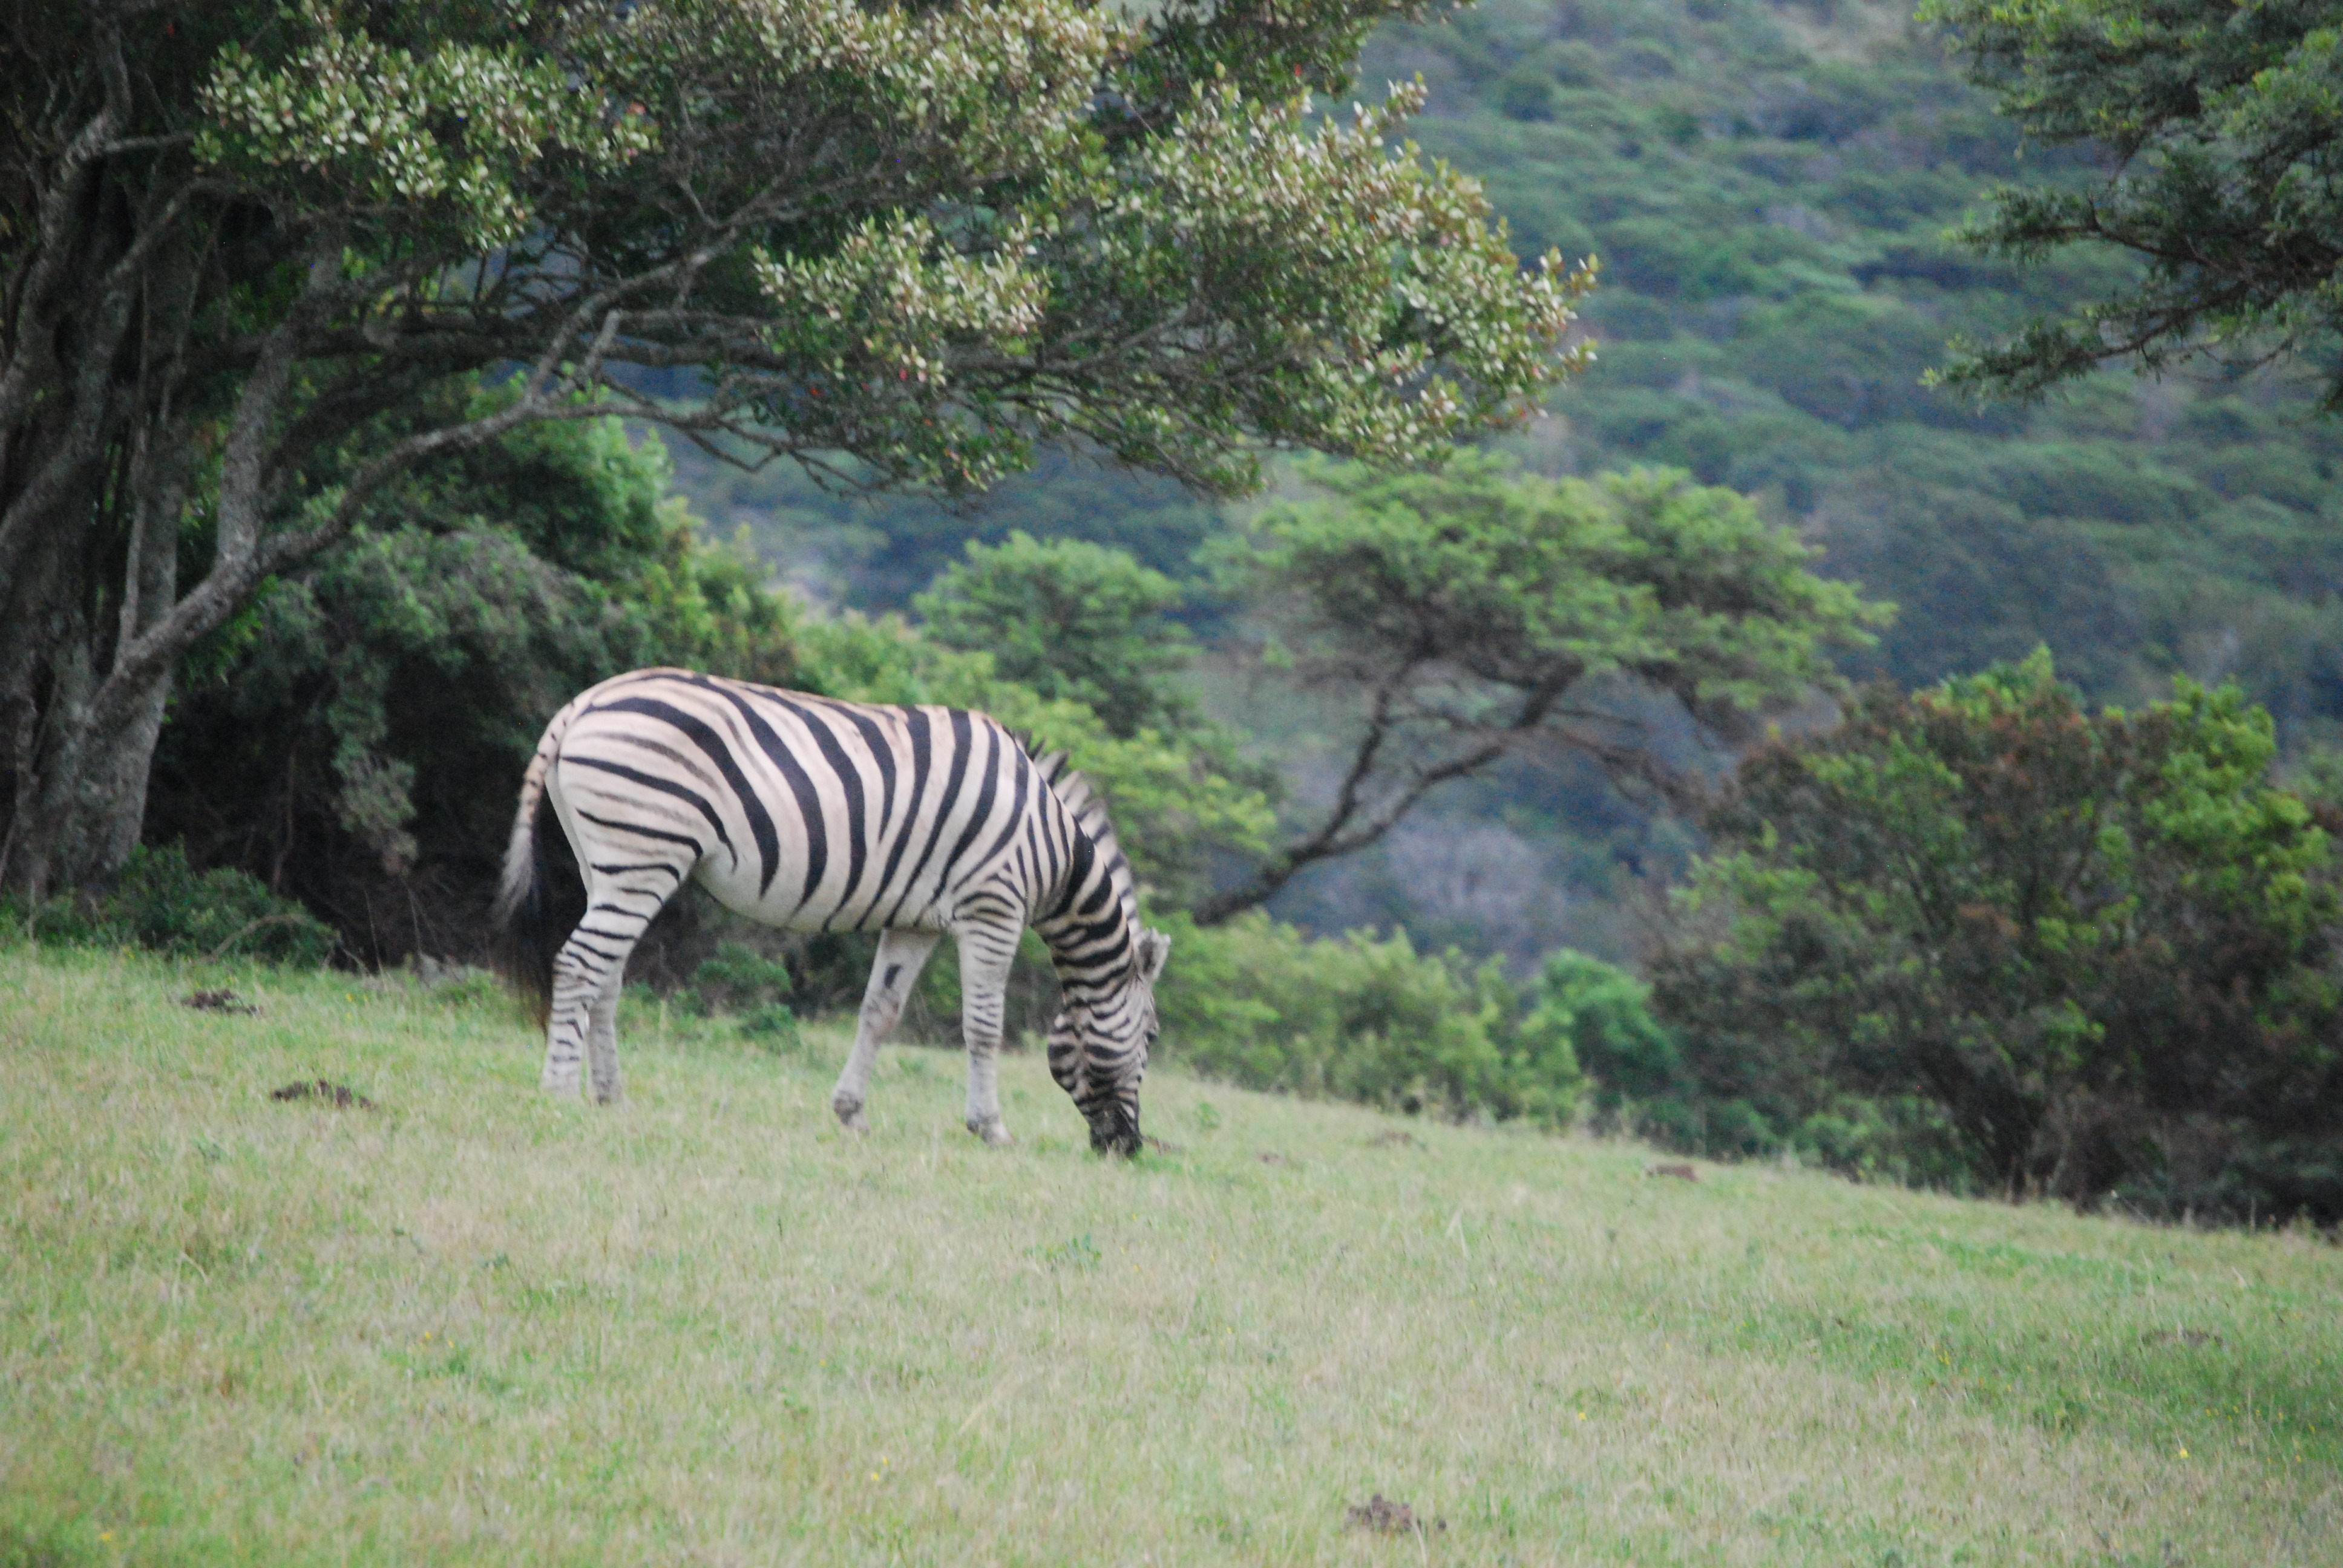

In [40]:
import IPython
IPython.display.Image(image_path, width = 400)

In [107]:
import sys
size = sys.getsizeof(image_path)
print(f"Size of image: {size} bytes")

Size of image: 58 bytes


In [109]:
%%time
from nomic import embed
import numpy as np

output = embed.images(
    images=[
        image_path,
    ],
    model='nomic-embed-vision-v1.5',
)

print(output['usage'])
embeddings = np.array(output['embeddings'])
print(embeddings.shape)
print(embeddings.ndim)
print(type(embeddings))

1
{'prompt_tokens': 196, 'total_tokens': 196}
{'prompt_tokens': 196, 'total_tokens': 196}
(1, 768)
2
CPU times: user 34.5 ms, sys: 35.4 ms, total: 69.9 ms
Wall time: 2.09 s


In [110]:
#inspect the embedings
print(embeddings)

[[-0.05258179  0.00206184 -0.03007507 -0.04260254 -0.03961182 -0.02090454
   0.04727173 -0.01215363 -0.05160522 -0.05285645  0.00630569 -0.01907349
  -0.03530884 -0.06524658 -0.06524658 -0.03421021  0.01270294 -0.02793884
   0.01852417 -0.02937317 -0.02546692  0.03744507 -0.02180481 -0.0524292
  -0.01211548 -0.02226257  0.03359985 -0.04458618 -0.0539856  -0.00614166
  -0.03016663 -0.00896454  0.01390839 -0.02626038 -0.0226593  -0.02854919
  -0.03430176 -0.04153442 -0.02424622 -0.03967285 -0.04864502 -0.05856323
  -0.03201294 -0.01425934  0.00574875 -0.02629089  0.00974274 -0.0607605
  -0.02772522 -0.01686096 -0.04855347 -0.04013062  0.03320312 -0.02319336
  -0.00339127  0.01858521 -0.07537842 -0.00850677  0.00984192 -0.008255
  -0.0131073  -0.03004456 -0.03320312 -0.01242065 -0.01277161 -0.00090218
  -0.05401611 -0.05844116 -0.01806641 -0.00997162 -0.02970886 -0.03527832
  -0.00749969 -0.03134155 -0.00019825 -0.02842712 -0.0166626  -0.04156494
   0.02352905 -0.02735901 -0.07440186  0.0

In [106]:
import sys
size = sys.getsizeof(embeddings)
print(f"Size of image: {size} bytes")

Size of image: 6272 bytes


## 2. Compare image embedding models

### CLIP Embeddings

In [70]:
import clip
model, preprocess = clip.load("ViT-B/32")

In [71]:
%%timeit
#check device
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

image_preprocess = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
image_embedding = model.encode_image(image_preprocess)

259 ms ± 6.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
image_embedding.shape

torch.Size([1, 512])

In [48]:
#image1_features

In [105]:
import sys
size = sys.getsizeof(image_embedding)
print(f"Size of image: {size} bytes")

Size of image: 72 bytes


## 3. Do similarity search with Nomic Vision Embed

In [63]:
#set the model
model = 'nomic-embed-vision-v1.5'

In [59]:
import torch
import clip
from PIL import Image
import os
import itertools
import torch.nn as nn

#check your device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

#create a list of the given images
dataset_folder = './elephants/'
images = []
for root, dirs, files in os.walk(dataset_folder):
    for file in files:
        if file.endswith(('jpg','jpeg')):
            images.append(  root  + '/'+ file)
            
print(f'number of images: {len(images)}')

cpu
number of images: 23


In [79]:
#Set the input image and create it's embedding

original_image = './elephants/1200px-Elephant_near_ndutu.jpg'

output1 = embed.images(images=[original_image], model=model)
embeddings1 = np.array(output1['embeddings'])
print(embeddings1.shape)
print(embeddings2.ndim)
print(type(embeddings1))

1
{'prompt_tokens': 196, 'total_tokens': 196}
(1, 768)
2
<class 'numpy.ndarray'>


In [103]:
second_image = './elephants/1200px-Asiatic_Elephant_Kabini.jpg'

output2 = embed.images(images=[second_image], model=model)
embeddings2 = np.array(output2['embeddings'])

1
{'prompt_tokens': 196, 'total_tokens': 196}


In [92]:
#do dimensionality reduction
emb1 = embeddings1.squeeze()
emb2 = embeddings2.squeeze()

print(emb1.shape)
print(emb2.shape)

(768,)
(768,)


In [89]:
#the cosine similarity function
def cosine_similarity(a, b):
    global similarity
    similarity =  np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return similarity

cosine_similarity(emb1, emb2)

In [102]:
#now calculate the cosine similarity for the list of images
result = {}
for img in images:
    output = embed.images(images=[img], model=model)
    emb = np.array(output['embeddings'])
    emb = emb.squeeze()
    cosine_similarity(emb1, emb)
    result[img]= similarity        

1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_tokens': 196}
1
{'prompt_tokens': 196, 'total_to

In [98]:
#sort the results and print the top 3
sorted_value = sorted(result.items(), key=lambda x:x[1], reverse=True)
sorted_res = dict(sorted_value)
top_3 = dict(itertools.islice(sorted_res.items(), 3))
print(top_3)

{'./elephants//1200px-Elephant_near_ndutu.jpg': 0.9999999999999999, './elephants//1280px-African_Elephant_(Loxodonta_africana)_male_(17289351322).jpg': 0.9733329535434488, './elephants//9033.ngsversion.1498856553498.adapt.1900.1.jpg': 0.9731723652075053}


The original image is:


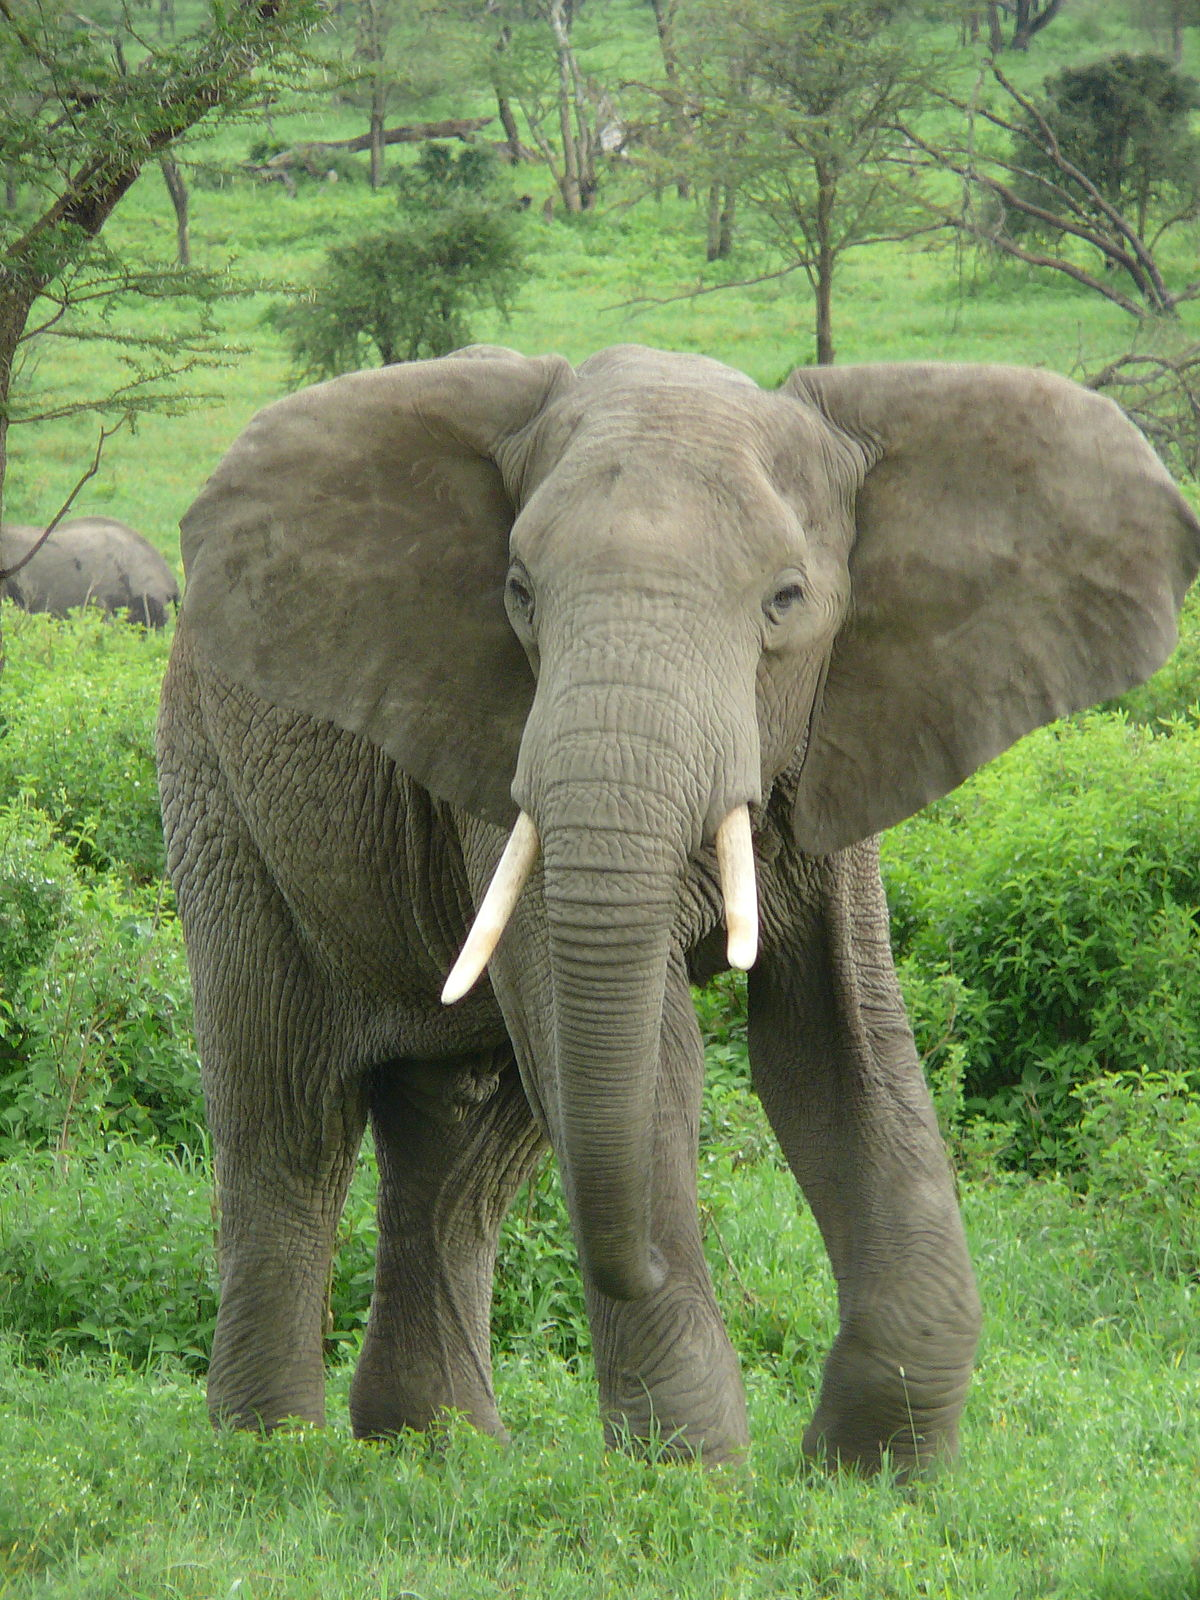

The duplicate is: 


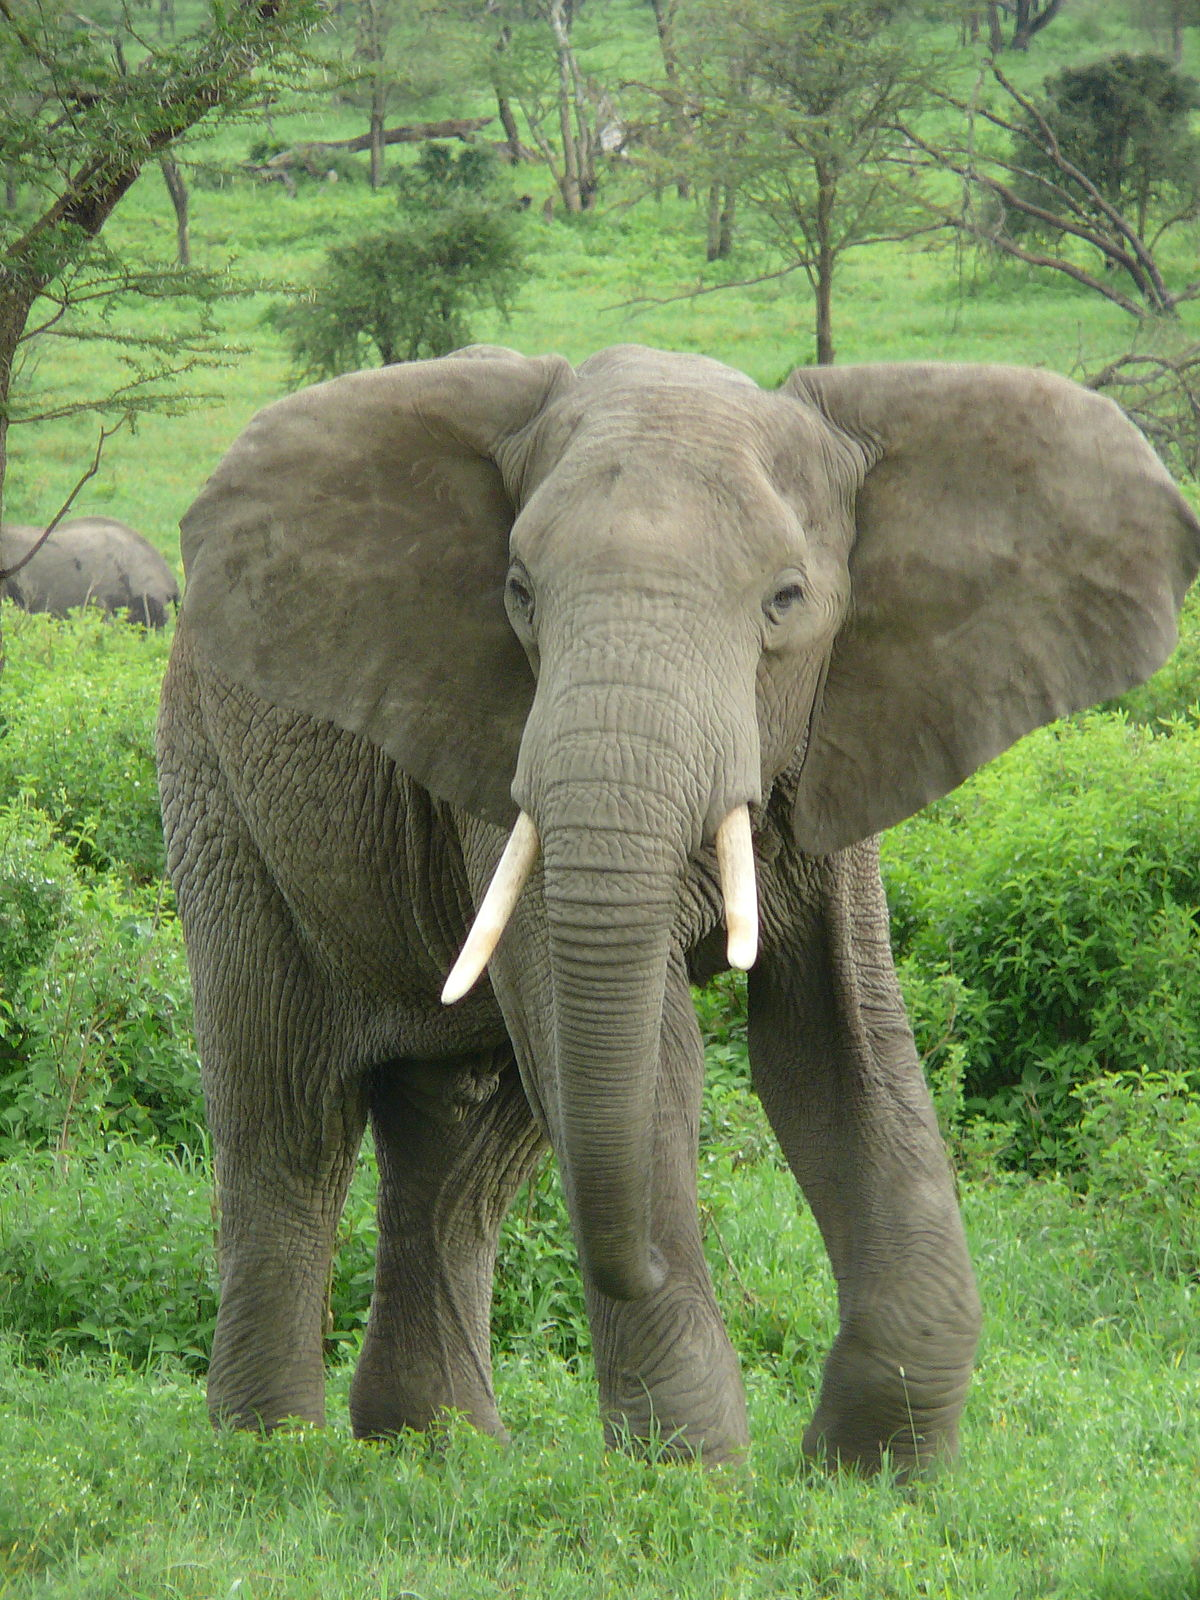

And the most similar images are:


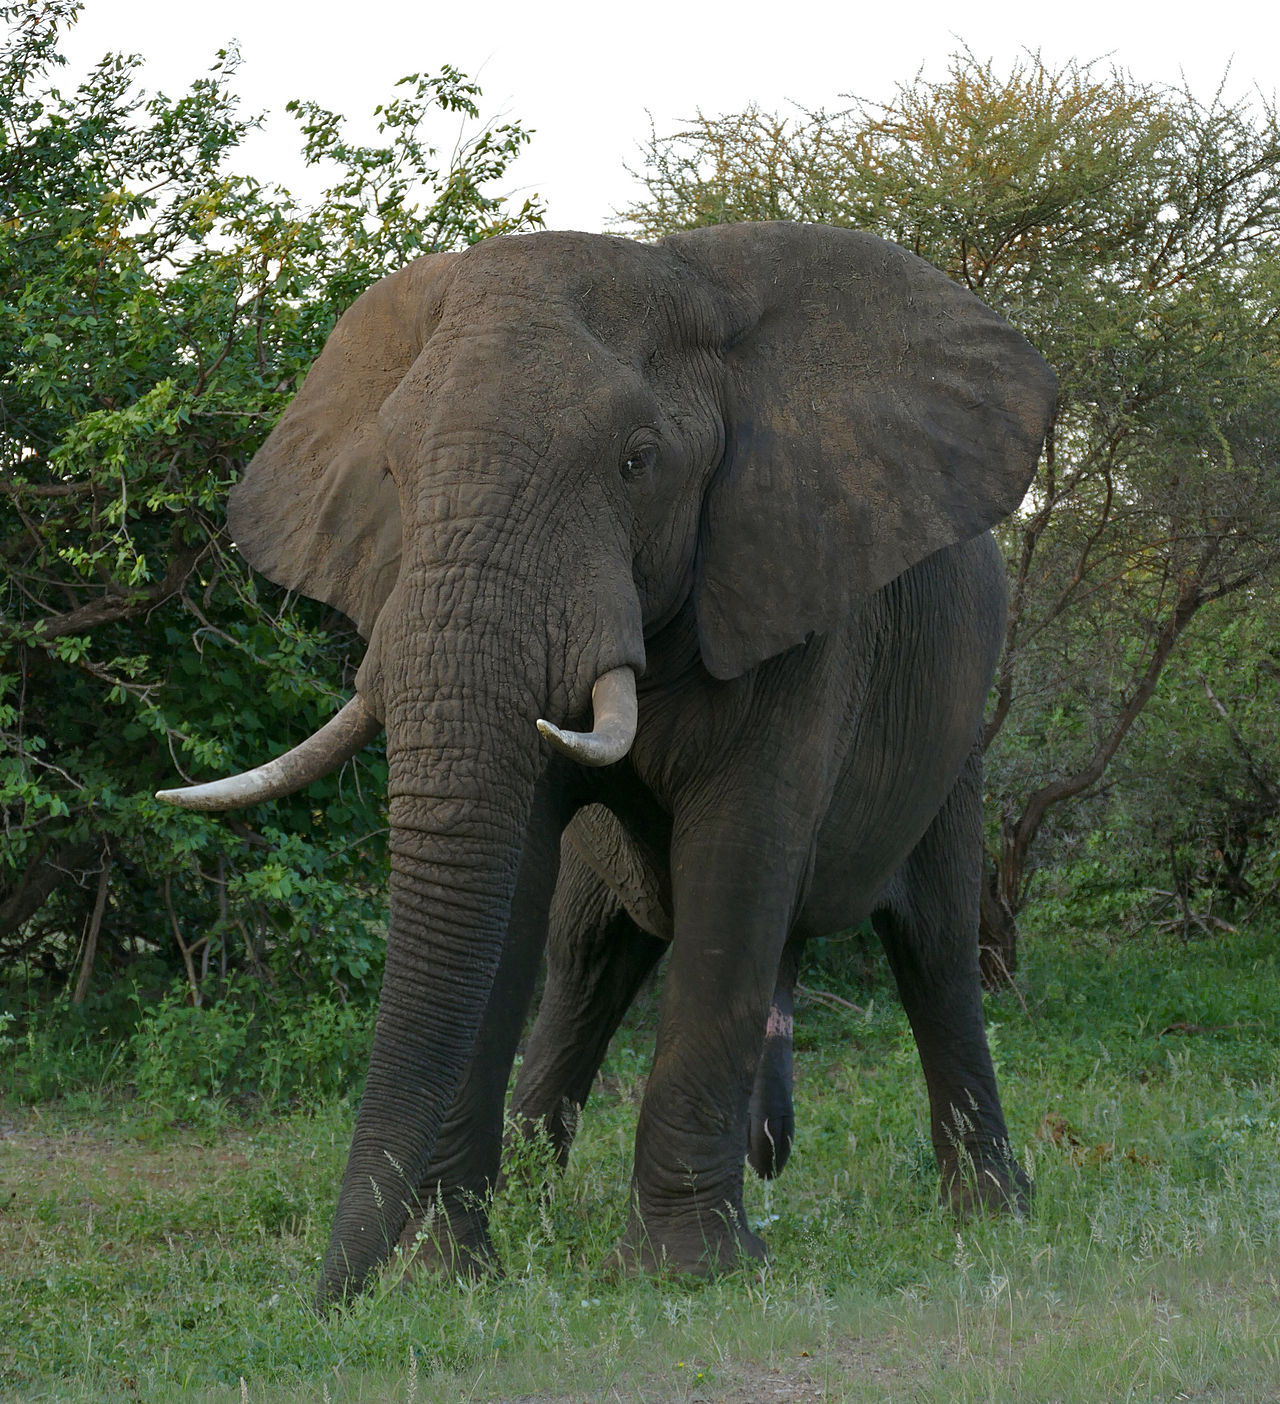

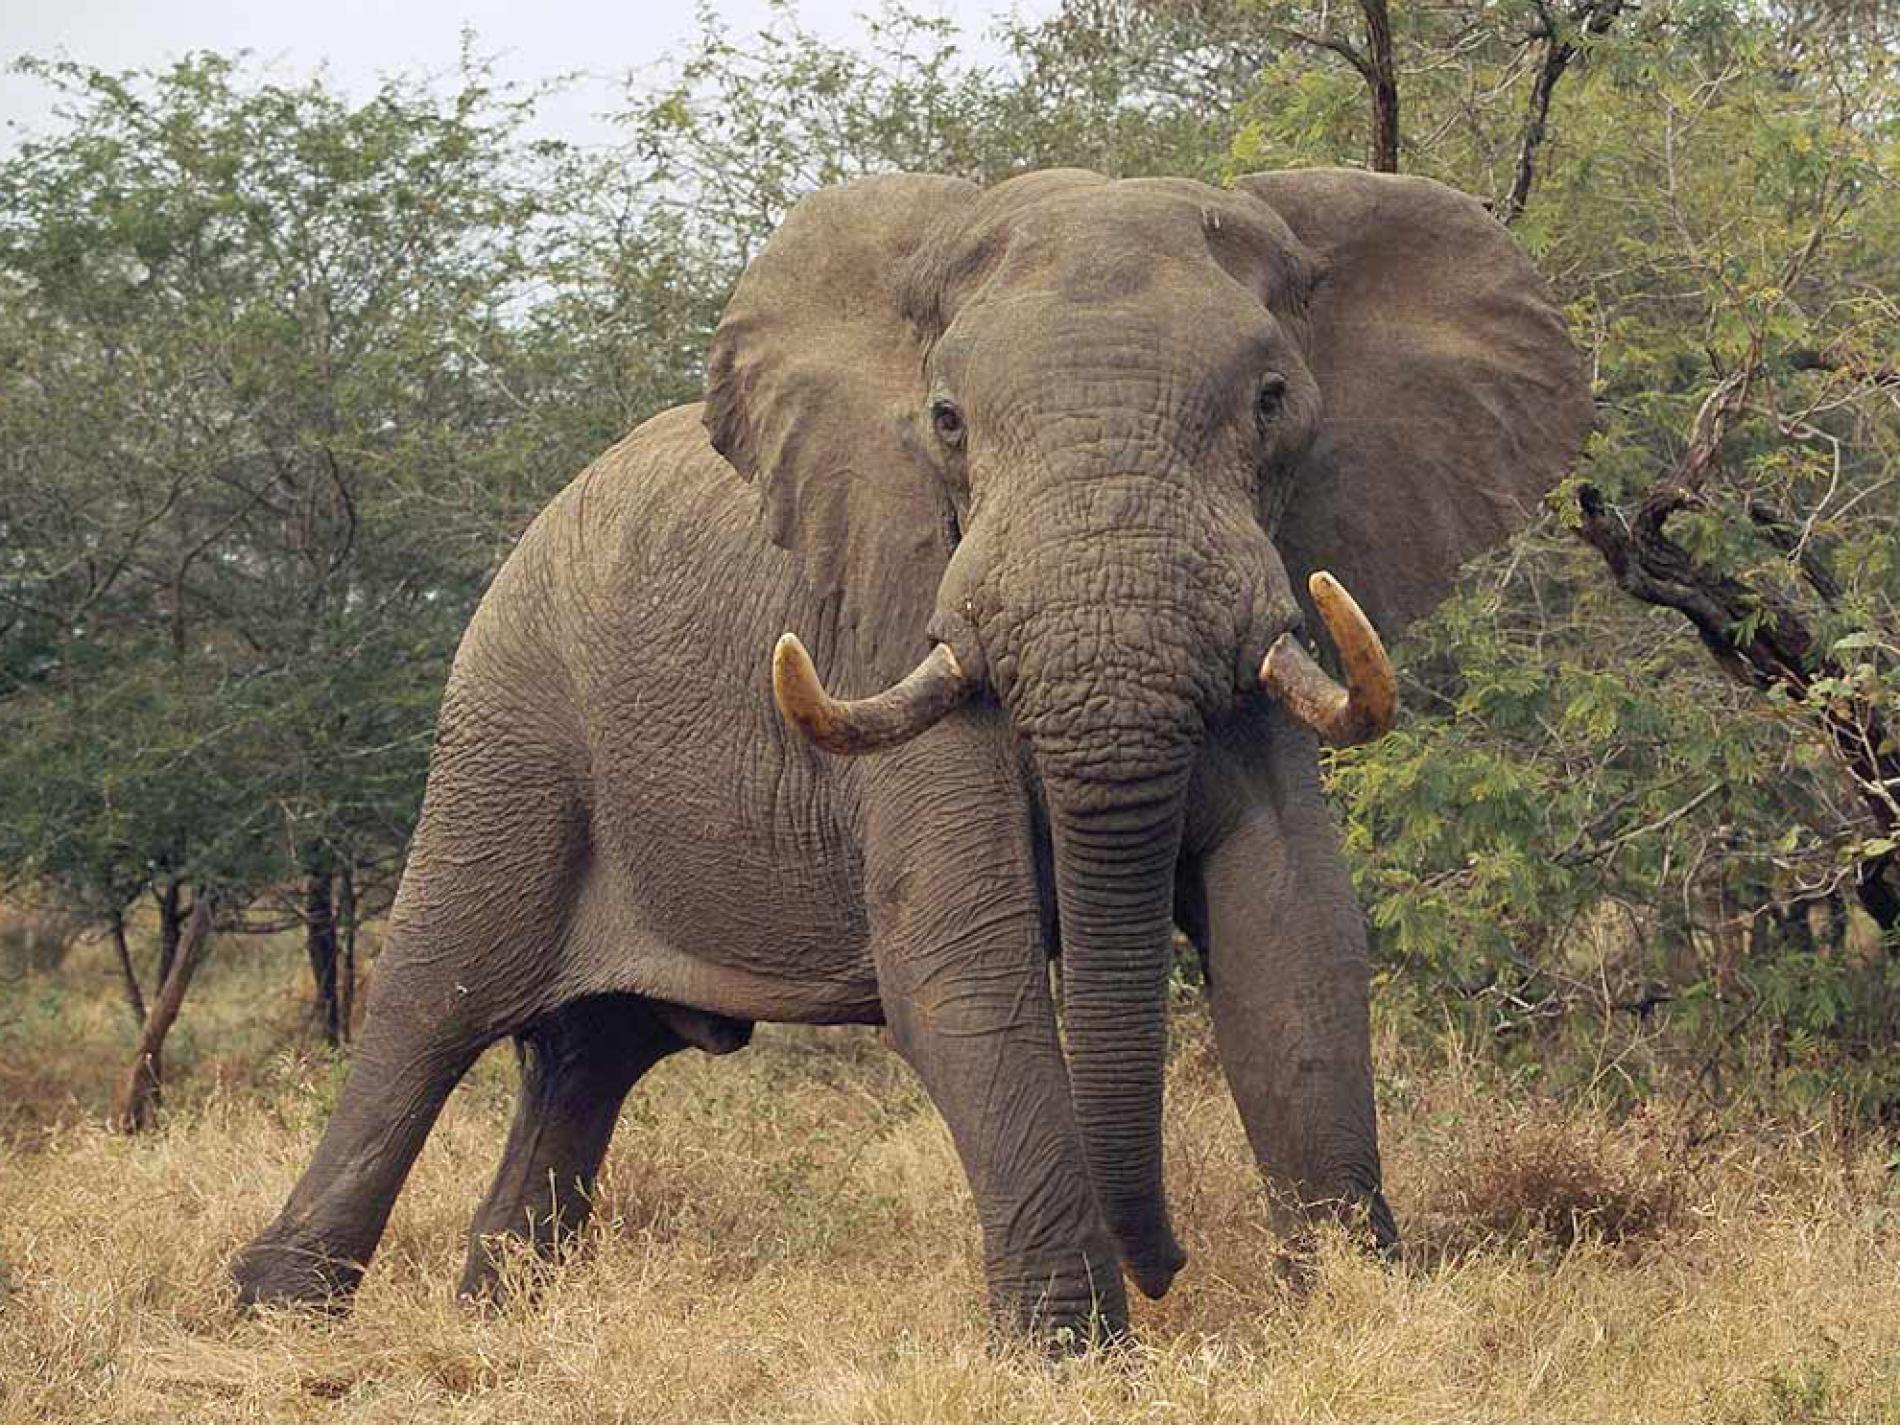

In [99]:
#display most similar images
from IPython.display import Image
from IPython.display import display

original_image = original_image
first = list(top_3.keys())[0]
second = list(top_3.keys())[1]
third = list(top_3.keys())[2]

#original image
img0 = Image(original_image, width = 400) 

#top 3
img1 = Image(first, width = 400) 
img2 = Image(second, width = 400) 
img3 = Image(third, width = 400)

print("The original image is:")
display(img0)
print('The duplicate is: ')
display(img1)
print('And the most similar images are:')
display(img2, img3)